# Analysis of Hotnet2 Data for GCN

In [117]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn

import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN

from sklearn.manifold import TSNE
%matplotlib inline

## Load Model, Data and Heat Scores

In [113]:
heat = pd.read_csv('../data/cancer/hotnet2/heats/pan12.gene2freq.txt', sep=' ', header=None, names=['heat'])
model_dir = '../data/GCN/training/2018_02_13_11_12_17/'
data_file = '../data/cancer/hotnet_iref_gcn_input_unbalanced.h5'
CLASSIFICATION_THRESHOLD = 0.6

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [114]:
# load predictions
predictions = pd.DataFrame.from_csv(model_dir + '/predictions.tsv', sep='\t', header=0)
features_df = pd.DataFrame(features, columns=['heat'], index=node_names[:, 0])
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner')
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID', 'Name'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['train_pos'] = y_train[:, 0]
labels_df['test_pos'] = y_test[:, 0]
labels_df['label'] = train_mask.astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive
labels_with_pred = labels_df.join(predictions)

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv(model_dir + '/positive_prediction.txt', sep='\t')
pos_predicted.sort_values(by='Prob_pos', ascending=False).head(10)

Predicted 1999 genes of 12129 total to be involved in infection


,heat,neighbors,Name,Prob_pos
PTEN,0.104502,43.0,PTEN,1.000000
PIK3CA,0.193569,45.0,PIK3CA,1.000000
TP53,0.415113,427.0,TP53,1.000000
CCND1,0.099035,67.0,CCND1,1.000000
KRAS,0.082637,23.0,KRAS,0.999999
MYC,0.090997,271.0,MYC,0.999999
CDKN2A,0.083280,75.0,CDKN2A,0.999998
MLL3,0.074277,16.0,MLL3,0.999993
APC,0.075241,121.0,APC,0.999987
ARID1A,0.062379,27.0,ARID1A,0.999966


## Overlap With Hotnet2 Results

In [115]:
# get the hotnet2 predicted subnetworks
res_dir = '../data/cancer/hotnet2/hotnet2_results/'
gene_lists = []
net_names = []
for f in os.listdir(res_dir):
    if f.endswith('.csv'):
        name = f.split('.')[0].strip()
        df = pd.read_csv(os.path.join(res_dir, f), sep='\t')
        net_names.append(name)
        genes = set(list(df.gene1) + list(df.gene2))
        gene_lists.append(list(genes))

# Look how many genes overlap
avg_percent = 0
for net_idx in range(len(gene_lists)):
    genes = gene_lists[net_idx]
    overlap = pos_predicted[pos_predicted.index.isin(genes)]
    percent = (overlap.shape[0] / float(len(genes))) * 100.
    avg_percent += percent
    print ("[{}] Overlap: {}/{} ({:.1f}%) genes".format(net_names[net_idx],
                                                                         overlap.shape[0],
                                                                         len(genes), percent))
print ('--------------------------')
print ("Average Overlap: {:.2f}%".format(avg_percent / float(len(gene_lists))))

[erbb_p53_net] Overlap: 50/52 (96.2%) genes
[notch_p53_net] Overlap: 58/62 (93.5%) genes
[ascom_pi3k_net] Overlap: 17/18 (94.4%) genes
[cohesin_pi3k] Overlap: 18/19 (94.7%) genes
[ascom_p53_net] Overlap: 51/51 (100.0%) genes
[ascom_condensin_net] Overlap: 10/12 (83.3%) genes
[ascom_keap1_net] Overlap: 10/11 (90.9%) genes
[boc_keap1_net] Overlap: 6/7 (85.7%) genes
[cohesin_notch_net] Overlap: 20/24 (83.3%) genes
[cohesin_swisnf_net] Overlap: 10/13 (76.9%) genes
[erbb_keap1_net] Overlap: 9/12 (75.0%) genes
--------------------------
Average Overlap: 88.55%


## Distribution of Predicted vs. Other Genes

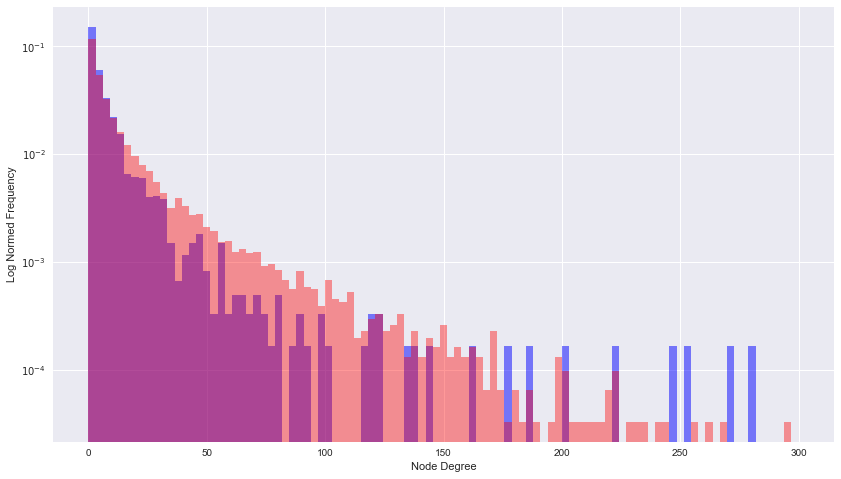

In [118]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, 300, 100)
x = plt.hist(pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD].neighbors,
         color='blue', alpha=.5, normed=True, bins=bins)
x = plt.hist(pred_with_feat[pred_with_feat.Prob_pos < CLASSIFICATION_THRESHOLD].neighbors,
         color='red', alpha=.4, normed=True, bins=bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('Node Degree')
plt.ylabel('Log Normed Frequency')

## Visualize Input Features

In [65]:
print ("Correlation of prediction with heat scores: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.heat)))
print ("Correlation of prediction with heat for positives: {}".format(pos_predicted.Prob_pos.corr(pos_predicted.heat)))

Correlation of prediction with heat scores: 0.4769426158178609
Correlation of prediction with heat for positives: 0.4608996580520745


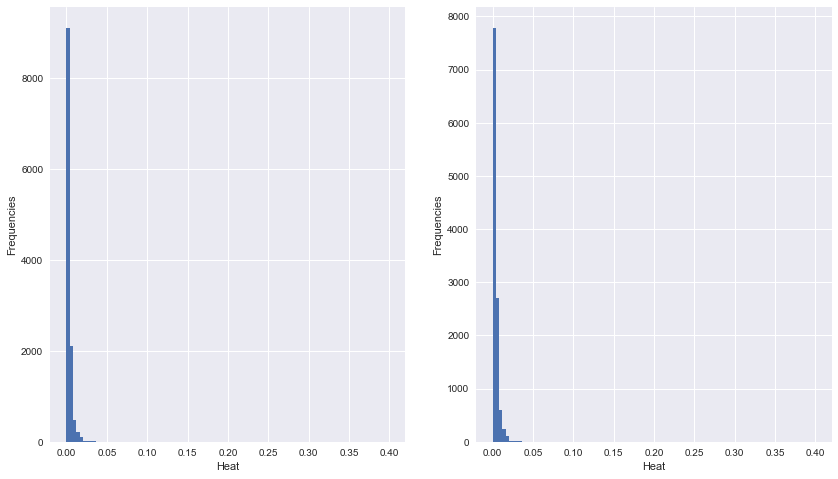

In [119]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, .4, 100)
plt.subplot(1, 2, 1)
x = plt.hist(features, bins=bins)
plt.xlabel('Heat')
plt.ylabel('Frequencies')
plt.subplot(1, 2, 2)
x = plt.hist(heat.heat, bins=bins)
plt.xlabel('Heat')
plt.ylabel('Frequencies')

In [67]:
import tensorflow as tf
from gcn.utils import *
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
#print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)

def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            key, value = line.split('\t')
            args[key.strip()] = str_to_num(value.strip())
    print ("Hyper-Parameters read from {}".format(file_name))
    return args

args = load_hyper_params(model_dir)

tf.reset_default_graph()
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)

poly_support = args['support']
if poly_support > 1:
    support = chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else:
    support = [preprocess_adj(adj)]
    num_supports = 1

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      num_hidden1=args['hidden1'],
                      num_hidden2=args['hidden2'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      logging=True)
        model.load(checkpoint_path, sess)

        feed_dict = construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        input_vals = model.activations[0]
        inp = sess.run(input_vals, feed_dict=feed_dict)


input_sp = coo_matrix((inp.values, (inp.indices[:, 0], inp.indices[:, 1])),
                        shape=inp.dense_shape)
input_np = np.array(input_sp.todense())
pd.get_dummies(input_np.squeeze()).head()

Hyper-Parameters read from ../data/GCN/training/2018_02_13_12_30_40/hyper_params.txt


/home/sasse/.local/lib/python3.6/site-packages/gcn-1.0-py3.6.egg/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power


Calculating Chebyshev polynomials up to order 2...
{'mygcn/gclayer_1_vars/weights_0:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_0:0' shape=(1, 50) dtype=float32_ref>, 'mygcn/gclayer_1_vars/weights_1:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_1:0' shape=(1, 50) dtype=float32_ref>, 'mygcn/gclayer_1_vars/weights_2:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_2:0' shape=(1, 50) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_0:0': <tf.Variable 'mygcn/gclayer_3_vars/weights_0:0' shape=(50, 1) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_1:0': <tf.Variable 'mygcn/gclayer_3_vars/weights_1:0' shape=(50, 1) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_2:0': <tf.Variable 'mygcn/gclayer_3_vars/weights_2:0' shape=(50, 1) dtype=float32_ref>}
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_02_13_12_30_40/model.ckpt
Model restored from file: ../data/GCN/training/2018_02_13_12_30_40/model.ckpt


,0.0,1.0
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0


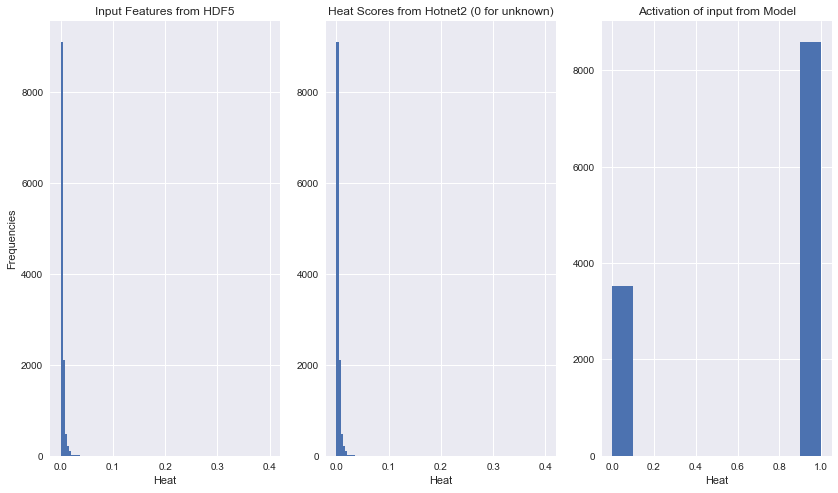

In [120]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, .4, 100)
plt.subplot(1, 3, 1)
x = plt.hist(features, bins=bins)
plt.xlabel('Heat')
plt.ylabel('Frequencies')
plt.title('Input Features from HDF5')
plt.subplot(1, 3, 2)
x = plt.hist(pred_with_feat.heat, bins=bins)
plt.xlabel('Heat')
plt.title('Heat Scores from Hotnet2 (0 for unknown)')
plt.subplot(1, 3, 3)
x = plt.hist(input_np)
plt.xlabel('Heat')
plt.title('Activation of input from Model')

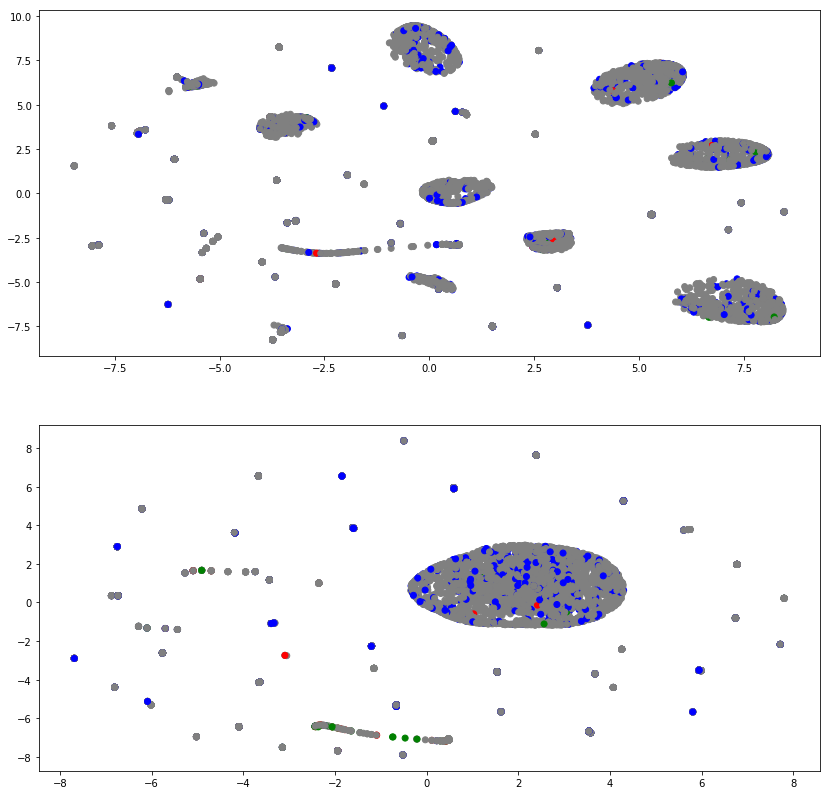

In [24]:
# build colors for TSNE plot
heat_with_labels = labels_with_pred.join(heat)
heat_with_labels.fillna(0, inplace=True)
heat_with_labels['color'] = 'grey'
heat_with_labels
heat_with_labels.loc[heat_with_labels.train_pos == 1, 'color'] = 'green'
heat_with_labels.loc[heat_with_labels.test_pos == 1, 'color'] = 'red'
heat_with_labels.loc[heat_with_labels.negative == 1, 'color'] = 'blue'

# calculate TSNE embedding for heat and features and plot it
emb = TSNE(n_components=2).fit_transform(heat)
emb2 = TSNE(n_components=2).fit_transform(features)
emb3 = TSNE(n_components=2).fit_transform(activation)
fig = plt.figure(figsize=(14, 14))
plt.subplot(2, 1, 1)
plt.scatter(emb[:, 0], emb[:, 1], c=heat_with_labels.color)
plt.subplot(2, 1, 2)
plt.scatter(emb2[:, 0], emb2[:, 1], c=heat_with_labels.color)